### Basic Generative Adversarial Network - Trained on MNIST DATASET

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
def show_images(image: torch.tensor, num_images = 25, size=(1, 28, 28), ax=None):
    image_unflat = image.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    if ax is not None:
        ax.imshow(image_grid.permute(1, 2, 0).squeeze())
    else:
        plt.imshow(image_grid.permute(1, 2, 0).squeeze())
        plt.axis("off")
        plt.show()

In [3]:
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            generator_block(z_dim, hidden_dim),
            generator_block(hidden_dim, hidden_dim*2),
            generator_block(hidden_dim*2, hidden_dim*4),
            generator_block(hidden_dim*4, hidden_dim*8),
            nn.Linear(hidden_dim*8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    def get_gen(self):
        return self.gen

In [5]:
def get_noise(n_samples, z_dim, device='cuda'):
    return torch.randn(n_samples, z_dim, device=device)

In [6]:
def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

In [7]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super().__init__()
        self.disc = nn.Sequential(
        discriminator_block(im_dim, hidden_dim*4),
        discriminator_block(hidden_dim*4, hidden_dim*2),
        discriminator_block(hidden_dim*2, hidden_dim),
        nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.disc(x)

    def get_disc(self):
        return self.disc

#### Checkpoints  were saved after training for 650 epochs.

In [8]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 1000
z_dim = 64
checkpoint_epoch = 25
batch_size = 128
lr = 0.00001
device = "cuda"
dataloader = DataLoader(
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
    )

In [9]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load("./gen_state"))
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc.load_state_dict(torch.load("./disc_state"))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [10]:
def get_disc_loss(gen, disc, criterion, real_images, num_images, z_dim, device):
    noise = get_noise(num_images, z_dim, device=device)
    # We are detaching the generating images so that when discriminator's loss.backward is called, its not backpropagated further backward from (and including) generated images. We really don't need extra computations :)
    generated_images = gen(noise).detach() # Shape (num_images, 784)
    disc_fake_pred = disc(generated_images) # Shape (num_images, 1)
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real_images) # Shape (num_real_images, 784)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_real_loss + disc_fake_loss) / 2
    return disc_loss


In [11]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    noise = get_noise(num_images, z_dim, device=device)
    generated_images = gen(noise)
    disc_pred = disc(generated_images)
    gen_loss = criterion(disc_pred, torch.ones_like(disc_pred))
    return gen_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Generator Loss: 0.953039 | Discriminator Loss: 0.573930


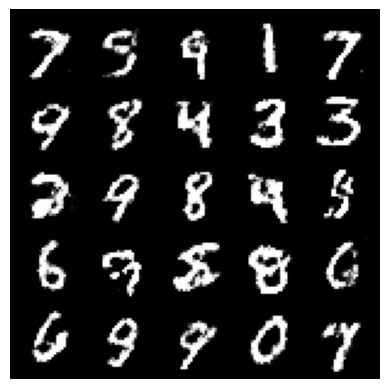

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Generator Loss: 1.091998 | Discriminator Loss: 0.574806


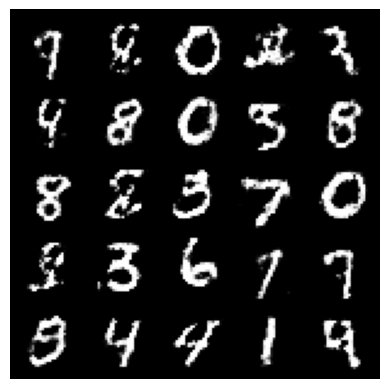

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Generator Loss: 0.945700 | Discriminator Loss: 0.627640


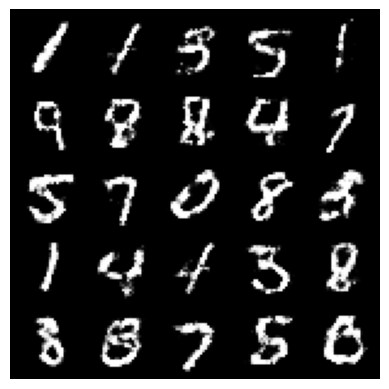

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Generator Loss: 1.032572 | Discriminator Loss: 0.591910


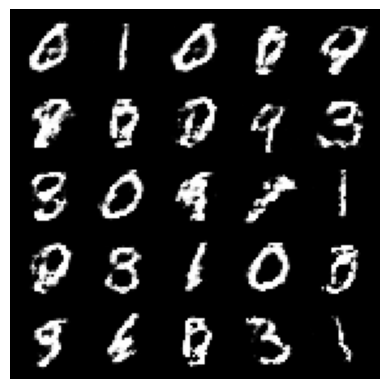

In [12]:
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        current_batch_size = len(real)
        disc_opt.zero_grad(set_to_none=True)
        real = real.view(current_batch_size, -1).to(device)
        disc_loss = get_disc_loss(gen, disc, criterion, real, current_batch_size, z_dim, device)
        # retain_graph=True? It works even if its not True
        disc_loss.backward()
        disc_opt.step()

        gen_opt.zero_grad(set_to_none=True)
        gen_loss = get_gen_loss(gen, disc, criterion, current_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
    if epoch % checkpoint_epoch == 0 and epoch > 0:
        print(f"Epoch {epoch}: Generator Loss: {gen_loss:2f} | Discriminator Loss: {disc_loss:2f}")
        fake_noise = get_noise(current_batch_size, z_dim, device=device)
        generated_images = gen(fake_noise) # Shape (batch_size, 784)
        show_images(generated_images)
        mean_discriminator_loss = 0
        mean_generator_loss = 0
        # torch.save(disc.state_dict(), f"./disc_state_{epoch+1}")
        # torch.save(gen.state_dict(), f"./gen_state_{epoch+1}")

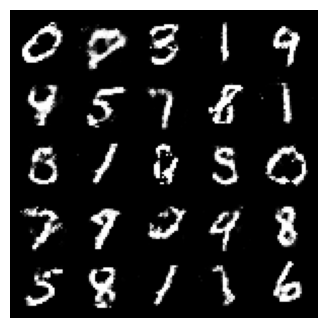

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
with torch.no_grad():
    noise = get_noise(25, z_dim, device=device)
    generated_images = gen(noise)
    show_images(generated_images)
fig.savefig("./output.png", dpi=200)